# When Computers Cry: Predicting Tearjerker Anime Using Scikit-learn

One of the few pieces of media to have ever coaxed tears from me is Kyoto Animation's devastating 2008 anime series *Clannad: After Story*, a show that I enthusiatically recommend. And I do so not in spite of the fact that it crushed my soul but because of it. If anything, I consider an anime's ability to turn on the waterworks to be a marker of quality. Most of my favorite anime are considered tearjerkers, *A Place Further than the Universe*, *Your Name*, and *K-On* come to mind as notable examples. Even if I don't tear up while watching them, a decent attempt made by an anime's creators still gets enormous credit from me. Given my afinity for such shows, wouldn't it be great if I could somehow predict whether an anime will trigger this emotional reaction from the audience? What if I could do so before it even airs?

Using data scraped off of the website MyAnimeList courtesy of , here's what I did . . .

1. Determined for anime whether each is a tearjerker or not based on the frequency of key words, "cry", "tears," etc., in their reviews.
2. Used the synopsis of the anime from MyAnimeList along with to predict 

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
# https://pub.towardsai.net/emoticon-and-emoji-in-text-mining-7392c49f596a
# https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7
from emot.emo_unicode import EMOTICONS_EMO, EMOJI_UNICODE
# https://www.kaggle.com/code/shsagar/finding-anime-genre-based-on-synopsis-logistic-reg
import nltk
from nltk.corpus import stopwords

# Wrangle Anime Data

In [19]:
# Load data
# https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews?select=animes.csv
animes = pd.read_csv("data/animes.csv") 
# https://www.kaggle.com/datasets/azathoth42/myanimelist?select=AnimeList.csv
AnimeList = pd.read_csv("data/AnimeList.csv")

In [20]:
AnimeList = AnimeList[["anime_id", 
                       "title_english", 
                       "title_synonyms", 
                       "type", 
                       "source", 
                       "producer", 
                       "licensor", 
                       "studio"]]
animes = animes.merge(AnimeList, how = "left", left_on = "uid", right_on = "anime_id")
anime = animes[["uid", 
                "title", 
                "synopsis", 
                "genre", 
                "type",
                "episodes", 
                "source", 
                "producer", 
                "licensor", 
                "studio"]]
anime = anime.drop_duplicates()
anime.head()

,uid,title,synopsis,genre,type,episodes,source,producer,licensor,studio
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",TV,25.0,Manga,"TOHO animation, Shueisha",Sentai Filmworks,Production I.G
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",TV,22.0,Manga,"Aniplex, Dentsu, Kodansha, Fuji TV, Kyoraku In...",Aniplex of America,A-1 Pictures
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",TV,13.0,Web manga,"Media Factory, AT-X, Takeshobo, Sony Music Com...",Sentai Filmworks,Kinema Citrus
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",TV,64.0,Manga,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",Movie,1.0,Light novel,"Aniplex, Kodansha",NaN,Shaft


# Construct Target Field

My target field comes from a dataset of anime reviews.

In [ ]:
# reviews = pd.read_csv("data/reviews.csv")
# reviews = reviews.drop_duplicates()

In [ ]:
# import math

# total_rows = len(reviews)
# max_rows = 10000
# num_files = math.ceil(total_rows/max_rows)

# start = 0
# end = 9999

# for i in range(1, num_files + 1):
#     i = str(i)
#     print("Writing file #" + i)
#     reviews.iloc[start:(end + 1), :].to_csv("data/reviews/reviews" + i + ".csv", index = False)
#     start += 10000
#     end += 10000

In [ ]:
# Read in data
reviews = pd.read_csv("data/reviews/reviews1.csv")
for i in range(2, 15):
    i = str(i)
    print("Concatenating data file #" + i)
    addition = pd.read_csv("data/reviews/reviews" + i + ".csv")
    reviews = pd.concat([reviews, addition])

In [ ]:
# Keep only relevant fields
reviews = reviews[["uid", "anime_uid", "link", "text"]]

In [ ]:
review_counts = reviews.groupby("anime_uid")["anime_uid"].count() 
keep_anime = review_counts[review_counts >= 30].index.tolist()
reviews = reviews[reviews["anime_uid"].isin(keep_anime)]

## Remove front and back matter

In [ ]:
reviews = reviews.reset_index(drop = True)
filler = re.compile(r"^[\s\w]*Enjoyment[\s\d]*|\s*Helpful\s*$")
reviews["text"] = reviews["text"].str.replace(filler, "")

## Drop titles

I intend to use the frequency of key words such as "cry" and "tears" in user reviews to determine whether an anime is a tearjerker or not. Some anime include these key words in their titles, meaning users really can't help but mention them in their reviews. Thus, to ensure that I'll only be counting authentic appearances of these terms, I exclude from the text of each review the title of the anime being discussed.

In [ ]:
reviews = reviews.merge(anime[["uid", "title"]], how = "left", left_on = "anime_uid", right_on = "uid")
reviews = reviews.drop(columns = "uid_y").rename(columns = {"uid_x": "uid"})
reviews["text"] = reviews["text"].str.lower()
reviews["title"] = reviews["title"].str.lower()

for i in range(len(reviews)):
    print("Processing row #" + str(i))
    title = reviews["title"].iloc[i]
    bigrams = reviews["title"].iloc[[i]].str.split().iloc[0]
    # http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
    bigrams = [" ".join(bigram) for bigram in list(zip(bigrams, bigrams[1:]))]
    pattern = "|".join([re.escape(title)] + [re.escape(bigram) for bigram in bigrams])
    reviews["text"].iloc[[i]] = reviews["text"].iloc[[i]].str.replace(pattern, "", regex = True)

## Test `TweetTokenizer()` from NLTK library

In [ ]:
used_emoticons.drop_duplicates().values

In [ ]:
used_emoticons[used_emoticons.iloc[:, 0] == "T.T"]

In [ ]:
reviews["text"].iloc[1148]

In [ ]:
from nltk.tokenize import TweetTokenizer
tweet = TweetTokenizer()
tweet.tokenize(reviews["text"].iloc[1148])

## Replace emoticons

The reviews feature heavy use of emoticons. These symbols allow their users to succintly communicate an emotional reaction through pictograms comprised of punctuation, letters, numbers, etc. Because they convey information on emotion, I want to retain them to help me determine whether an anime is a tearjerker or not. However, since they include punctuation, which will be removed from the text later on in the process of constructing the target field, I opted to replace them with verbal descriptions.

I used a dictionary of emoticons from the emo_unicode library . . .

In [ ]:
# http://introtopython.org/dictionaries.html#General-Syntax
emoticons = {}
for symbol, meaning in EMOTICONS_EMO.items():
    emoticons[symbol] = "".join([word.capitalize() for word in meaning.replace(",", "").split()])

. . . and added a few missing emoticons.

In [ ]:
emoticons["(^—^)"] = "NormalLaugh"
# https://en.wikipedia.org/wiki/List_of_emoticons
emoticons[">W<"] = "Troubled"
emoticons["-_-'"] = "Troubled"
# https://www.urbandictionary.com/define.php?term=%3E_%3E
emoticons[">_>"] = "RightSidewaysLook"
emoticons["<_<"] = "LeftSidewaysLook"

Since many long emoticons are simply short ones with additional characters, I sorted the emoticons in descending order according to their length so that, later on, the longer emoticons would be matched prior to shorter emoticons. 

In [ ]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
# https://www.w3schools.com/python/ref_func_sorted.asp
emoticons = dict(sorted(emoticons.items(), key = lambda item: -len(item[0])))

I then assembled a list of the emoticons from the dictionary that were used in the reviews. I managed to get , but I'm sure I missed some T_T.

In [ ]:
# https://www.pythonforbeginners.com/basics/list-comprehensions-in-python
# https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
# https://stackoverflow.com/questions/4202538/escape-special-characters-in-a-python-string
pattern = "\s(" + "|".join([re.escape(emoticon) for emoticon in emoticons]) + ")\W?"
used_emoticons = reviews["text"].str.extractall(pattern)

Here, I'm converting the dataframe of used emoticons into a dictionary.

In [ ]:
# https://www.digitalocean.com/community/tutorials/python-convert-numpy-array-to-list
used_emoticons = used_emoticons.dropna().drop_duplicates().values.reshape(1, -1)[0].tolist()
# https://stackoverflow.com/questions/5352546/extract-subset-of-key-value-pairs-from-dictionary
used_emoticons = {symbol: emoticons[symbol] for symbol in used_emoticons}

Again, I'm sorting the emoticons according to their length.

In [ ]:
used_emoticons = dict(sorted(used_emoticons.items(), key = lambda item: -len(item[0])))

Now, I'm looping through each emoticon and replacing it with its respective value in the dictionary if it's preceded by a white space and followed by a non-word character. These conditions are to reduce the likelihood of false-positives.

In [ ]:
for symbol, meaning in used_emoticons.items():
    print("Replacing " + symbol + " with " + meaning)
    reviews["text"] = reviews["text"].str.replace("(?<=\s)" + re.escape(symbol) + "(?=\W?)", meaning, regex = True)

In [ ]:
# reviews.to_csv("data/intermediates/replace_emoticons.csv", index = False)
reviews = pd.read_csv("data/intermediates/replace_emoticons.csv")

## Replace emojis

In [ ]:
emojis = {}
for meaning, symbol in EMOJI_UNICODE.items():
    emojis[symbol] = "_".join(meaning.lower().replace(",", "").replace(":", "").split())
emojis['❤️'] = "heart"
emojis['♥️'] = "heart"

In [ ]:
pattern = "(" + "|".join([re.escape(emoji) for emoji in emojis]) + ")"
used_emojis = reviews["text"].str.extractall(pattern)

In [ ]:
reviews["text"].iloc[[19803]].str.contains('☺')

In [ ]:
print(reviews["link"].iloc[19803])

In [ ]:
used_emojis = used_emojis.dropna().drop_duplicates().values.reshape(1, -1)[0].tolist()
# used_emojis = {symbol: emojis[symbol] for symbol in used_emojis}
# for symbol, meaning in used_emojis.items():
#     print("Replacing " + symbol + " with " + meaning)
#     reviews["text"] = reviews["text"].str.replace(symbol, " " + meaning + " ", regex = False)
used_emojis

In [ ]:
final_characters = reviews["text"].str.extract(r"(?P<final_character>.$)", expand = False)

In [ ]:
pd.set_option("display.max_rows", None)
final_characters = reviews["text"].str.extract(r"(?P<final_character>.$)")
counts = final_characters.groupby("final_character")["final_character"].count()

In [ ]:
list(counts.index)

In [ ]:
reviews["text"][final_characters['final_character'] == '️']

In [ ]:
counts[counts.index == '️']
# '⠀', '️', '̿'

## Tokenize text

In [ ]:
reviews["text"] = reviews["text"].str.strip()
reviews["text"] = reviews["text"].str.lower()
reviews["text"] = reviews["text"].str.replace("\\", " ", regex = True)
reviews["text"] = reviews["text"].str.replace("/", " ")                                      
reviews["text"] = reviews["text"].str.replace("‘", "'").str.replace("’", "'")
reviews["text"] = reviews["text"].str.replace("“", '"').str.replace("”", '"')
pattern = "[" + string.punctuation.replace("'", "").replace("-", "") + "–" + "…" + "]" 
pattern = pattern + r"|(?<=\s)'(?=\w)|(?<=\w)'(?=\s)"
reviews["text"] = reviews["text"].str.replace(pattern, "", regex = True)
reviews["text"] = reviews["text"].str.split()

In [ ]:
reviews = reviews.explode("text")

## Replace non-word characters except for emojis and select punctuation

I will drop all non-word characters that aren't emojis. First, I create a list of the unique non-word characters present in the reviews.

In [ ]:
unique_tokens = reviews["text"].drop_duplicates()
non_word = unique_tokens.str.extractall(r"(\W)").drop_duplicates()
non_word = non_word.values.reshape(1, -1)[0].tolist()

Next, I reformat the definitions from the emoji dictionary that I obtained from the emot library.

In [ ]:
emojis = {}
for meaning, symbol in EMOJI_UNICODE.items():
    emojis[symbol] = meaning 

I created a regex pattern that separates all the characters that I want to be dropped by a pipe, `|`.

In [ ]:
drop = [char for char in non_word if char not in emojis]
drop.remove("'")
drop.remove("-")
drop = "|".join(drop) # Create regex pattern

Using the pattern created above, I replaced the non-word characters I specified with empty strings.

In [ ]:
reviews["text"] = reviews["text"].str.replace(drop, "", regex = True)
reviews = reviews[reviews["text"] != ""]

In [ ]:
# reviews["text"].loc[168].values
# reviews["text"].loc[281].values.tolist()

## Remove stopwords

In [ ]:
nltk.download("stopwords")
stopwords = list(stopwords.words("English"))

In [ ]:
reviews = reviews[~reviews["text"].isin(stopwords)]

In [2]:
# reviews.to_csv("data/intermediates/cleaned_text.csv", index = False)
reviews = pd.read_csv("data/intermediates/cleaned_text.csv")

## Add target field

In [3]:
# keep = [emoji for emoji in emojis if emoji in non_word]

In [4]:
key_words = ["cry", 
             "cried", 
             "crying", 
             "sob", 
             "sobbed", 
             "sobbing", 
             "bawl", 
             "bawled", 
             "bawling", 
             "tear", 
             "tears", 
             "teared", 
             "tearing", # as in "tearing up"
             "sadorcrying",
             "tearsofhappiness",
             "sadofcrying",
             "😭"]
reviews["cry"] = reviews["text"].isin(key_words)

In [5]:
# cry_prop = reviews.groupby("anime_uid").agg(
#     cry = pd.NamedAgg(column = "cry", aggfunc = "mean"),
#     n = pd.NamedAgg(column = "uid", aggfunc = "nunique")
# ).reset_index()

In [6]:
# cry_prop.to_csv("data/intermediates/target_field.csv", index = False)
# cry_prop = pd.read_csv("data/intermediates/target_field.csv")

In [10]:
cry_vote = reviews.groupby(["uid", "anime_uid"])["cry"].sum() > 0
cry_vote = cry_vote.reset_index().groupby("anime_uid")["cry"].mean().reset_index()
cry_vote = cry_vote.rename(columns = {"cry": "cry_vote"})

In [18]:
# cry_vote.to_csv("data/intermediates/cry_vote.csv", index = False)
cry_vote = pd.read_csv("data/intermediates/cry_vote.csv")

# Visualizations

*True Tears* is an outlier here because one of its characters' ability to cry is a central plot point. Thus, reviewers who are summarizing its story mention crying quite a lot even after scrubbing its reviews of any mention of the title.

In [21]:
anime = cry_vote.merge(anime, how = "left", left_on = "anime_uid", right_on = "uid").drop(columns = "anime_uid")
anime[["title", "uid", "cry_vote"]].sort_values("cry_vote", ascending = False).head(10)

,title,uid,cry_vote
261,Clannad: After Story,4181,0.698492
400,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,9989,0.679012
208,True Tears,2129,0.575000
132,Hotaru no Haka,578,0.532258
872,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,35851,0.490000
796,Violet Evergarden,33352,0.487624
693,Gintama°,28977,0.473684
669,Plastic Memories,27775,0.460784
177,Kanon (2006),1530,0.460317
565,Love Live! School Idol Project 2nd Season,19111,0.450000


Text(0.5, 0, 'Proportion of reviews that mention crying')

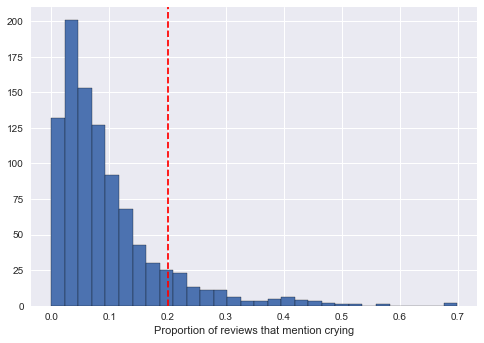

In [22]:
plt.style.use("seaborn")
anime["cry_vote"].hist(bins = 30, edgecolor = "black")
plt.vlines(x = 0.2, ymin = 0, ymax = 350, color = "red", linestyles = "dashed")
plt.ylim(bottom = 0, top = 210)
plt.xlabel("Proportion of reviews that mention crying")

In [23]:
(anime["cry_vote"] >= 0.20).mean()

0.10973084886128365